In [1]:
from glob import glob

# use any data you want
dari_pasentran = glob('/home/husein/youtube/malay/dari-pasentran-ke-istana/*/*.wav')
turki = glob('/home/husein/youtube/malay2/turki/*/*.wav')
salina = glob('/home/husein/youtube/malay2/salina/*/*.wav')
len(dari_pasentran), len(turki), len(salina)

(9168, 2621, 12579)

In [2]:
husein = glob('/home/husein/speech-bahasa/audio-wattpad/*.wav')
husein.extend(glob('/home/husein/speech-bahasa/audio-iium/*.wav'))
husein.extend(glob('/home/husein/speech-bahasa/audio/*.wav'))
len(husein)

2394

In [3]:
haqkiem = glob('/home/husein/speech-bahasa/haqkiem/*.wav')
len(haqkiem)

4294

In [4]:
vctk = glob('vtck/**/*.flac', recursive = True)
len(vctk)

88328

In [7]:
from collections import defaultdict
import random

vctk_speakers = defaultdict(list)
for f in vctk:
    s = f.split('/')[-1].split('_')[0]
    vctk_speakers[s].append(f)
    
speakers = []
    
for s in vctk_speakers.keys():
    speakers.extend(random.sample(vctk_speakers[s], min(400, len(vctk_speakers[s]))))
    
len(speakers)

43618

In [8]:
import malaya_speech

In [9]:
import IPython.display as ipd

ipd.Audio(vctk[0])

In [10]:
config = {'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 20,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [11]:
import numpy as np
import librosa

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [12]:
from tqdm import tqdm

def process(files, silent_trail = 500, maxlen = 25):
    files = files[0]
    audios, mels = [], []
    for f in files:
        audio, _ = malaya_speech.load(f, sr = config['sampling_rate'])
        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue
        
        D = librosa.stft(
            audio,
            n_fft=config['fft_size'],
            hop_length=config['hop_size'],
            win_length=config['win_length'],
            window=config['window'],
            pad_mode='reflect',
        )
        S, _ = librosa.magphase(D) 
        fmin = 0 if config["fmin"] is None else config["fmin"]
        fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
        mel_basis = librosa.filters.mel(
            sr=config['sampling_rate'],
            n_fft=config["fft_size"],
            n_mels=config["num_mels"],
            fmin=fmin,
            fmax=fmax,
        )
        mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]
        
        audios.append(audio)
        mels.append(mel)
    
    return [[audios, mels]]

In [13]:
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

In [14]:
i = 135
r = process((husein[i: i + 10],))[0]

In [15]:
k = 0

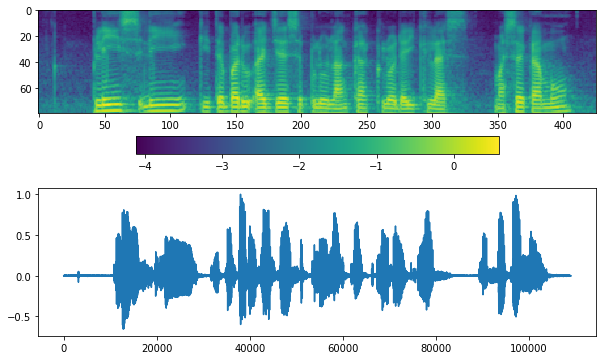

In [16]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(10)
fig.set_figheight(nrows * 3)
mel_outputs_ = np.reshape(r[1][k], [-1, 80])
im = ax[0].imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax[0])
ax[1].plot(r[0][k])
plt.show()

In [17]:
import mp
import random

files = dari_pasentran + turki + salina + husein + haqkiem + speakers
audios, mels = [], []

In [18]:
batch_size = 2000
for i in range(0, len(files), batch_size):
    index = min(i + batch_size, len(files))
    b = files[i: index]
    results = mp.multiprocessing(b, process, cores = 20, returned = True)
    for result in results:
        audios.extend(result[0])
        mels.extend(result[1])
    print(f'done {i}')

done 0
done 2000
done 4000
done 6000
skipped, audio too long
skipped, audio too long
skipped, audio too long
skipped, audio too long
done 8000
skipped, audio too long
skipped, audio too long
skipped, audio too long
skipped, audio too long
skipped, audio too long
skipped, audio too long
done 10000
done 12000
done 14000
done 16000
done 18000
done 20000
done 22000
done 24000
done 26000
done 28000
done 30000
done 32000
done 34000
done 36000
done 38000
done 40000
done 42000
done 44000
done 46000
done 48000
done 50000
done 52000
done 54000
done 56000
done 58000
done 60000
done 62000
done 64000
done 66000
done 68000
done 70000
done 72000
done 74000


In [20]:
from sklearn.preprocessing import StandardScaler

scaler_mel = StandardScaler(copy=False)

for mel in tqdm(mels):
    scaler_mel.partial_fit(mel)

100%|██████████| 74664/74664 [01:00<00:00, 1238.73it/s]


In [21]:
for i in tqdm(range(len(mels))):
    mels[i] = scaler_mel.transform(mels[i])

100%|██████████| 74664/74664 [00:25<00:00, 2892.31it/s]


In [22]:
directory_stats = 'universal-stats'

In [23]:
def save_statistics_to_file(scaler_list, config):
    os.system(f'mkdir {directory_stats}')
    for scaler, name in scaler_list:
        stats = np.stack((scaler.mean_, scaler.scale_))
        np.save(
            os.path.join(f"{directory_stats}/stats{name}.npy"),
            stats.astype(np.float32),
            allow_pickle=False,
        )

In [25]:
import os

scaler_list = [(scaler_mel, "")]
save_statistics_to_file(scaler_list, config)

In [26]:
directory = 'output-universal'

In [27]:
!rm -rf {directory}

In [28]:
os.system(f'mkdir {directory}')
directories = ['audios', 'mels']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [29]:
for i in tqdm(range(len(mels))):
    np.save(f'{directory}/audios/{i}.npy', audios[i])
    np.save(f'{directory}/mels/{i}.npy', mels[i])

100%|██████████| 74664/74664 [12:11<00:00, 102.07it/s]
